In [8]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results
import numpy as np


  0%|          | 0/2019 [00:00<?, ?it/s]

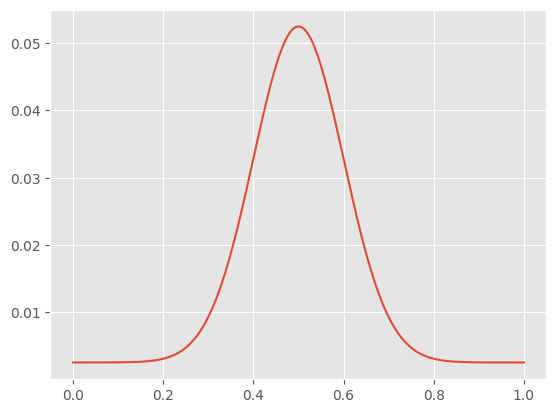

In [116]:
import numpy as np
from scipy.sparse import diags_array
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.sparse.linalg import spsolve
from tqdm.auto import tqdm
from scipy.sparse import identity
from scipy.sparse import eye_array


def heat_step(k,kappa_func,n):
    h = 1/(n+1)
    xgrid = np.linspace(0,1,n+2)
    kappa = kappa_func(xgrid[1:-1]).reshape(-1,1)
    L = diags_array([np.ones(n-1),-2 * np.ones(n),np.ones(n-1)],offsets = [-1,0,1])/(h**2)
    L = kappa * L
    B = L * k
    I = eye_array(n)
    L1 = I - B/4
    R1 = I + B/4
    L2 = I - B/3
    def trbdf2_heat(u):
        u1 = spsolve(L1,R1@u)
        return spsolve(L2,(1/3) * (4 * u1 - u))
    return trbdf2_heat

def get_inhomogeneous_heat_solver(kappa_func,k = 1e-4,n = 1000):
    xgrid = np.linspace(0,1,n+2)
    stepper = heat_step(k,kappa_func,n)
    
    def solve_heat(u0,final_t = 1.):
        num_timesteps = final_t//k
        u_vals = [u0]
        u = u0
        for i in tqdm(range(int(num_timesteps))):
            u = stepper(u)
            u_vals+=[u]
        return np.array(u_vals),np.arange(0,final_t,k)
    return xgrid,solve_heat

k = 5e-4

kappa_func = lambda x:0.05*(0.05 + np.exp( - (x - 0.5)**2 / (0.02)))
def func_u0(x):
    u0 = 0.25  * np.sin(np.pi*x) + 3 * np.sin(2*np.pi*x)**2
    return u0

grid,solver = get_inhomogeneous_heat_solver(kappa_func,k,n = 1999)

u0 = func_u0(grid)[1:-1]

sols,tvals = solver(u0,1.01)
sols = np.hstack([np.zeros((len(sols),1)),sols,np.zeros((len(sols),1))])

plt.plot(grid,kappa_func(grid))
from scipy.interpolate import RectBivariateSpline

interpolant = RectBivariateSpline(tvals,grid,sols)
def u_true_function(x):
    return interpolant(x[:,0],x[:,1],grid = False)

def ut_true_function(x):
    ut_interp = interpolant.partial_derivative(1,0)
    return ut_interp(x[:,0],x[:,1],grid = False)

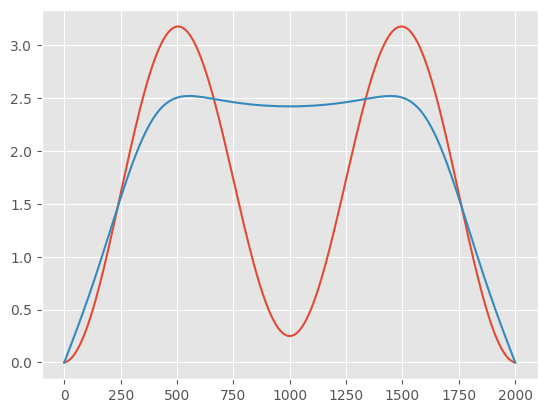

In [117]:
plt.plot(sols[0])
plt.plot(sols[-1])

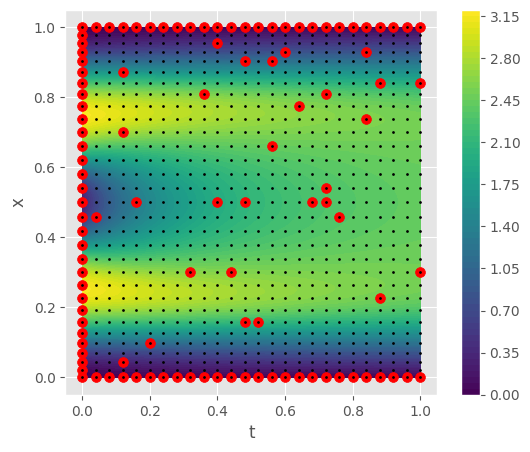

In [123]:
num_grid_x = 31
num_grid_t = 26
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.4)


num_points = 40#old value
tx_all,tx_obs = setup_problem_data(
    tx_int,
    tx_bdy,
    30,
    jax.random.PRNGKey(120),
    times_to_observe = (0,)
)

u_true = u_true_function(tx_all)
u_obs = u_true_function(tx_obs)

num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

def plot_input_data(
    obs_points,
    all_points,
    func_to_plot,
    fine_grid,
    xlabel = 't',
    ylabel = 'x',
    include_collocation = True
):
    plt.figure(figsize=(6,5))

    x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
    y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],func_to_plot(fine_grid),75)
    plt.colorbar()
    plt.scatter(obs_points[:,0],obs_points[:,1],c='red', s = 50,label = "Function Value Observed")
    if include_collocation is True:
        plt.scatter(all_points[:,0],all_points[:,1],c='black',s = 2,label = "Collocation Point")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_bounds[0] - 0.05,x_bounds[1] + 0.05)
    plt.ylim(y_bounds[0] - 0.05,y_bounds[1] + 0.05)
    #plt.figlegend(loc = 'upper center')


plot_input_data(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
)
plt.savefig("juan_nu_heat/data.svg")

In [108]:
#Alternate lengthscale computation

# from Kernels import (
#     get_centered_scaled_poly_kernel,
#     get_anisotropic_gaussianRBF,
#     fit_kernel_params,
#     setup_matern,log1pexp,
#     get_rq_kernel
# )
# from functools import partial

# # base_kernel_family = setup_matern(5)
# # def param_kernel(x,y,params):
# #     lengthscales = log1pexp(params)
# #     rootD = jnp.diag(jnp.sqrt(lengthscales))
# #     return base_kernel_family(1.)(rootD@x,rootD@y)


# base_kernel_family = get_rq_kernel(1.)
# def param_kernel(x,y,params):
#     lengthscales = log1pexp(params)
#     rootD = jnp.diag(jnp.sqrt(lengthscales))
#     return base_kernel_family(rootD@x,rootD@y)

# fitted_params = fit_kernel_params(param_kernel,tx_obs,u_obs,2*jnp.ones(2))
# ML_inv_lengthscales = log1pexp(fitted_params)


# print(1/(ML_inv_lengthscales))

# #k_u = partial(param_kernel,params = fitted_params + 2.)

# def k_u(x,y):
#     inv_lengthscales = log1pexp(fitted_params)
#     rootD = jnp.diag(jnp.sqrt(inv_lengthscales))
#     return base_kernel_family(rootD@x,rootD@y)


In [125]:
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dx_k,dxx_k)

from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params,get_gaussianRBF
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dx_k,dxx_k)

from Kernels import log1pexp,inv_log1pexp

def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(
    param_ani_gaussian_RBF,tx_obs,u_obs,
    jnp.ones(2),
    stepsize = 1e-6,
    maxiter = 5000
    )
ML_lengthscales = log1pexp(fitted_params)

k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))
print(1/(jnp.sqrt(ML_lengthscales)))

u_model = CholInducedRKHS(
    tx_all,
    feature_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_init,c=1.,scaling = 'diagonal')
k_P_x_part = get_gaussianRBF(0.25)

@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:]) * k_P_x_part(x[1:2],y[1:2])


P_model = OperatorModel(k_P)    
    

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 200
)

[0.34573796 0.14199397]


In [126]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution

params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])

params,convergence_data = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 1001,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)

  0%|          | 0/1001 [00:00<?, ?it/s]

Iteration 0, loss = 0.1999, Jres = 12.56, alpha = 0.08333, improvement_ratio = 1.001
Iteration 1, loss = 0.09931, Jres = 2.025, alpha = 0.06944, improvement_ratio = 1.026
Iteration 2, loss = 0.06383, Jres = 0.8854, alpha = 0.05787, improvement_ratio = 0.9906
Iteration 3, loss = 0.04489, Jres = 0.518, alpha = 0.04823, improvement_ratio = 0.9803
Iteration 4, loss = 0.03363, Jres = 0.3838, alpha = 0.04019, improvement_ratio = 0.9778
Iteration 5, loss = 0.02652, Jres = 0.3027, alpha = 0.03349, improvement_ratio = 0.9793
Iteration 100, loss = 0.0006596, Jres = 0.272, alpha = 2.279e-05, improvement_ratio = 0.7426
Iteration 200, loss = 0.000425, Jres = 0.3885, alpha = 7.631e-06, improvement_ratio = 0.7297
Iteration 300, loss = 0.000301, Jres = 0.8428, alpha = 1.775e-06, improvement_ratio = 0.7556
Iteration 400, loss = 0.0002326, Jres = 0.8274, alpha = 1.479e-06, improvement_ratio = 0.6659
Iteration 500, loss = 0.0002014, Jres = 0.4497, alpha = 1.479e-06, improvement_ratio = 0.759
Iteration 60

  0%|          | 0/700 [00:00<?, ?it/s]

Iteration 0, loss = 0.00012683527691429195
Iteration 50, loss = 0.00012172583296501554
Iteration 100, loss = 0.00011541858184381426
Iteration 150, loss = 0.00011009976640957257
Iteration 200, loss = 0.00010582784603569941
Iteration 250, loss = 0.00010166744710596704
Iteration 300, loss = 9.809281947685596e-05
Iteration 350, loss = 9.428226916097415e-05
Iteration 400, loss = 9.093932280552252e-05
Iteration 450, loss = 8.755428563590651e-05
Iteration 500, loss = 8.439963433320543e-05
Iteration 550, loss = 8.125423295816058e-05
Iteration 600, loss = 7.857693681563944e-05
Iteration 650, loss = 7.545632625177212e-05


/tmp/ipykernel_2859525/3118025129.py:6: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


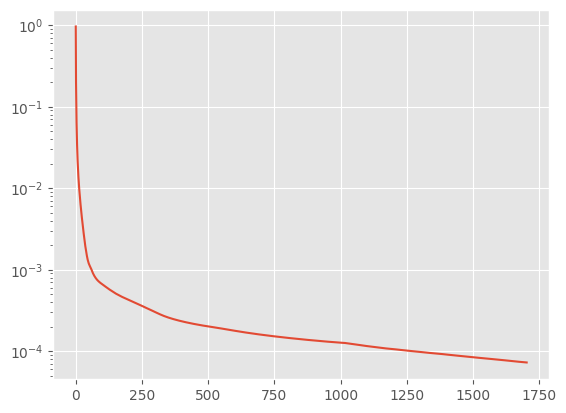

In [127]:
p_adjusted,refine_convergence_data = adaptive_refine_solution(
    params,EqnModel,1e-3,700,
    tol = 1e-14,min_iter = 300,
    print_every = 50
    )
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

Pre Refinement PDE MSE 0.00015117371274373816
Post Refinement PDE MSE 7.360317527579916e-05


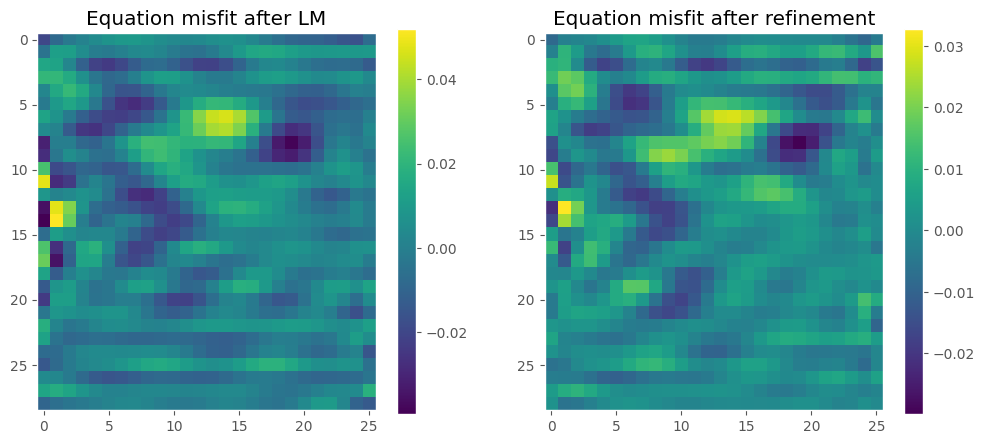

In [128]:
equation_residuals = EqnModel.equation_residual(params)
equation_residuals_refined = EqnModel.equation_residual(p_adjusted)

print("Pre Refinement PDE MSE",jnp.mean(equation_residuals**2))
print("Post Refinement PDE MSE",jnp.mean(equation_residuals_refined**2))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Equation misfit after LM")
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t)[::-1])
plt.grid(None)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Equation misfit after refinement")
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t)[::-1])
plt.grid(None)
plt.colorbar()
plt.show()


,NRMSE,NMAE
1 Step,0.017484,0.011411
2 Step,0.045513,0.029971


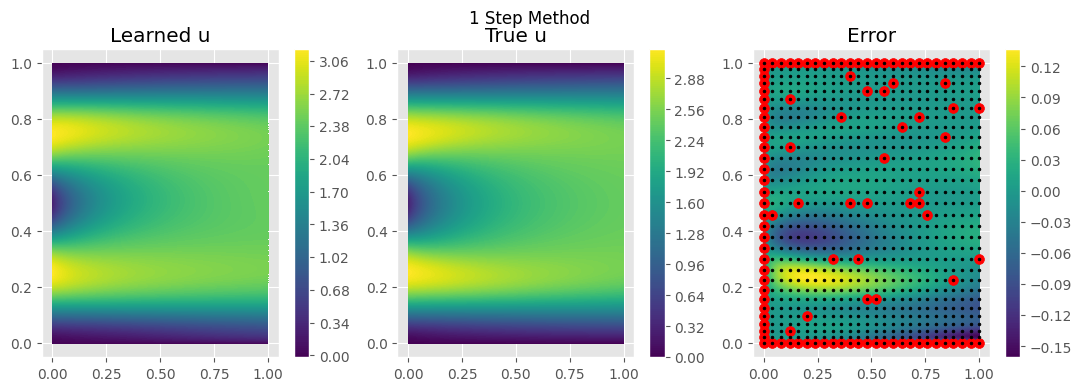

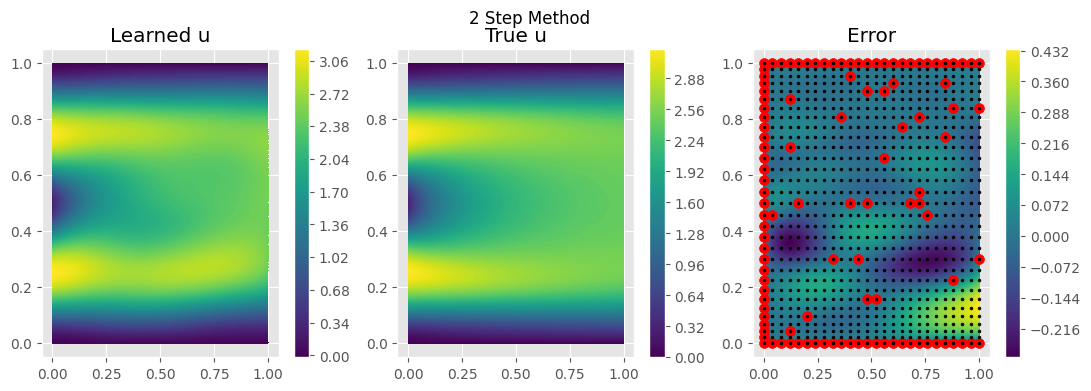

In [129]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]


num_fine_grid = 250
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1 Step Method"
)

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)

In [132]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interpolant.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interpolant.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interpolant.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = jnp.linalg.solve(K+1e-8*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = EqnModel.get_single_eqn_features(u_model,u_params_init,tx_fine_int)
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

compute_results(
    ut_true,
    {
        "1 Step Model Features":preds_ut_model_features,
        "1 Step True Features":preds_ut_true_features,
        "2 Step Model Features": P_preds_init_model_features_init,
        "2 Step True Features":P_preds_init_true_features,
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
)

,NRMSE,NMAE
1 Step Model Features,0.135427,0.148005
1 Step True Features,0.518722,0.527320
2 Step Model Features,0.413118,0.505777
2 Step True Features,0.794208,1.001987


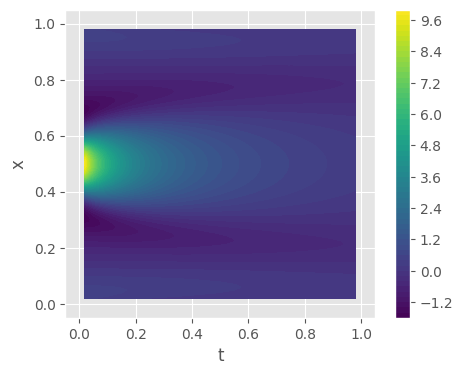

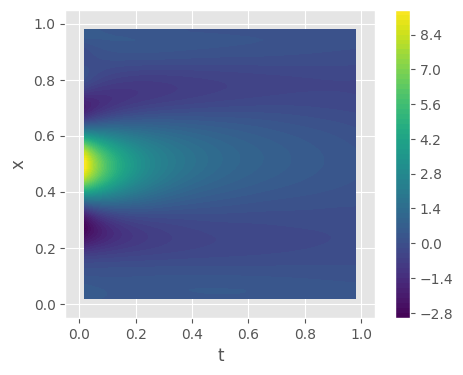

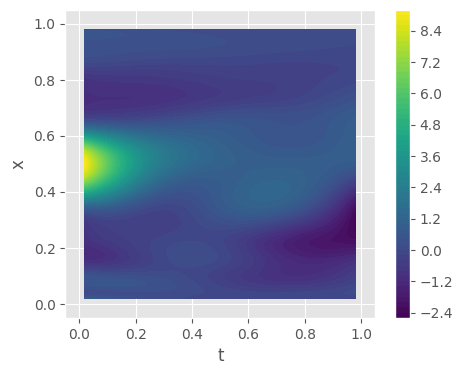

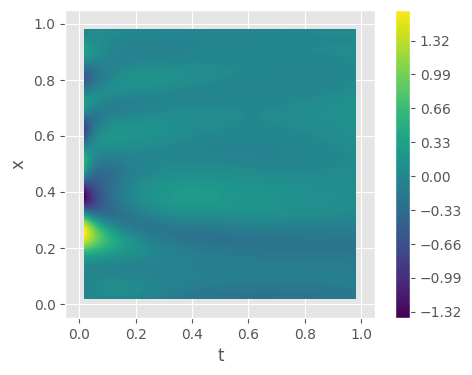

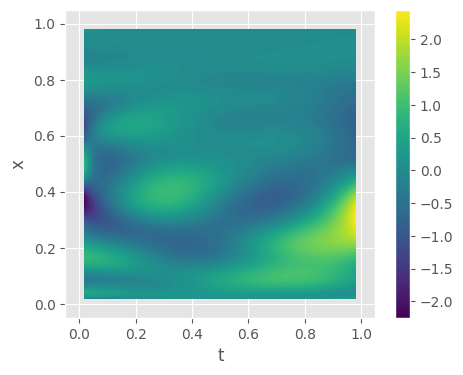

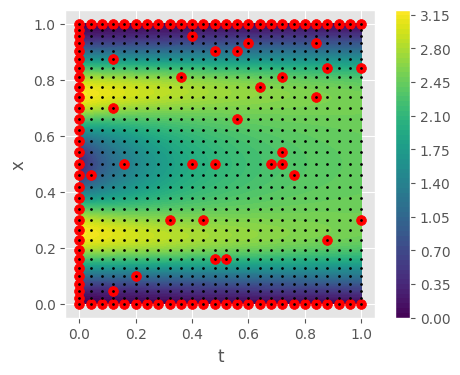

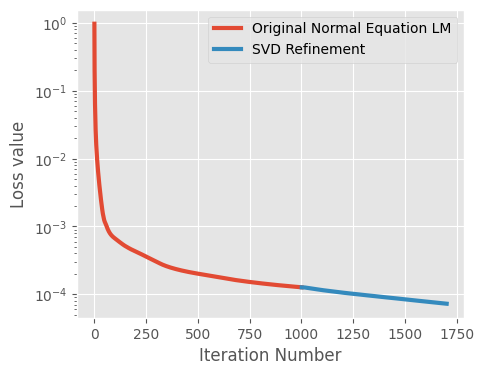

In [136]:
plt.figure(figsize=(5,4))
plt.xlabel('t')
plt.ylabel('x')
plt.xlim(0 - 0.05,1 + 0.05)
plt.ylim(0 - 0.05,1 + 0.05)


keql_ut_pred = preds_ut_model_features
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,75)
plt.colorbar()
plt.savefig("juan_nu_heat/true_ut.svg")
plt.show()


plt.figure(figsize=(5,4))
plt.xlabel('t')
plt.ylabel('x')
plt.xlim(0 - 0.05,1 + 0.05)
plt.ylim(0 - 0.05,1 + 0.05)


keql_ut_pred = preds_ut_model_features
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],keql_ut_pred,75)
plt.colorbar()
plt.savefig("juan_nu_heat/learned_1step_ut.svg")
plt.show()

two_step_ut_pred = P_preds_init_model_features_init
plt.figure(figsize=(5,4))
plt.xlabel('t')
plt.ylabel('x')
plt.xlim(0 - 0.05,1 + 0.05)
plt.ylim(0 - 0.05,1 + 0.05)
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],two_step_ut_pred,75)
plt.colorbar()
plt.savefig("juan_nu_heat/learned_2step_ut.svg")
plt.show()

true_vals = u_true_function(tx_grid_fine)
pred_vals = u_model.point_evaluate(tx_grid_fine,u_sol)
plt.figure(figsize=(5,4))
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1], ut_true-keql_ut_pred,100)
plt.xlabel('t')
plt.ylabel('x')
plt.xlim(0 - 0.05,1 + 0.05)
plt.ylim(0 - 0.05,1 + 0.05)
plt.colorbar()
plt.savefig("juan_nu_heat/error_1step_ut.svg")
plt.show()

true_vals = u_true_function(tx_grid_fine)
pred_vals_2step = u_model.point_evaluate(tx_grid_fine,u_params_init)
plt.figure(figsize=(5,4))
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1], ut_true-two_step_ut_pred,100)
plt.xlabel('t')
plt.ylabel('x')
plt.xlim(0 - 0.05,1 + 0.05)
plt.ylim(0 - 0.05,1 + 0.05)
plt.colorbar()
plt.savefig("juan_nu_heat/error_2step_ut.svg")
plt.show()

def plot_input_data(
    obs_points,
    all_points,
    func_to_plot,
    fine_grid,
    xlabel = 't',
    ylabel = 'x',
    include_collocation = True
):
    plt.figure(figsize=(5,4))

    x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
    y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],func_to_plot(fine_grid),75)
    plt.colorbar()
    plt.scatter(obs_points[:,0],obs_points[:,1],c='red', s = 50,label = "Function Value Observed")
    if include_collocation is True:
        plt.scatter(all_points[:,0],all_points[:,1],c='black',s = 2,label = "Collocation Point")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_bounds[0] - 0.05,x_bounds[1] + 0.05)
    plt.ylim(y_bounds[0] - 0.05,y_bounds[1] + 0.05)
    #plt.figlegend(loc = 'upper center')


plot_input_data(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
)
plt.savefig("juan_nu_heat/data.svg")
plt.show()

plt.figure(figsize=(5,4))
plt.plot(range(len(convergence_data['loss_vals'])),convergence_data['loss_vals'],lw = 3,label = "Original Normal Equation LM")
plt.plot(
    jnp.arange(len(convergence_data['loss_vals']),len(convergence_data['loss_vals']) + len(refine_convergence_data['loss_vals'])),
    refine_convergence_data['loss_vals'],lw = 3,label = 'SVD Refinement'
    )
plt.yscale('log')
plt.legend()
plt.ylabel("Loss value")
plt.xlabel("Iteration Number")
plt.savefig("juan_nu_heat/loss.svg")
plt.show()

In [137]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interpolant.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interpolant.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interpolant.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = jnp.linalg.solve(K+1e-8*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = EqnModel.get_single_eqn_features(u_model,u_params_init,tx_fine_int)
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

df_errors_ut = compute_results(
    ut_true,
    {
        "1 Step Model Features":preds_ut_model_features,
        "1 Step True Features":preds_ut_true_features,
        "2 Step Model Features": P_preds_init_model_features_init,
        "2 Step True Features":P_preds_init_true_features,
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
)

In [138]:
df_errors_ut

,NRMSE,NMAE
1 Step Model Features,0.135427,0.148005
1 Step True Features,0.518722,0.527320
2 Step Model Features,0.413118,0.505777
2 Step True Features,0.794208,1.001987


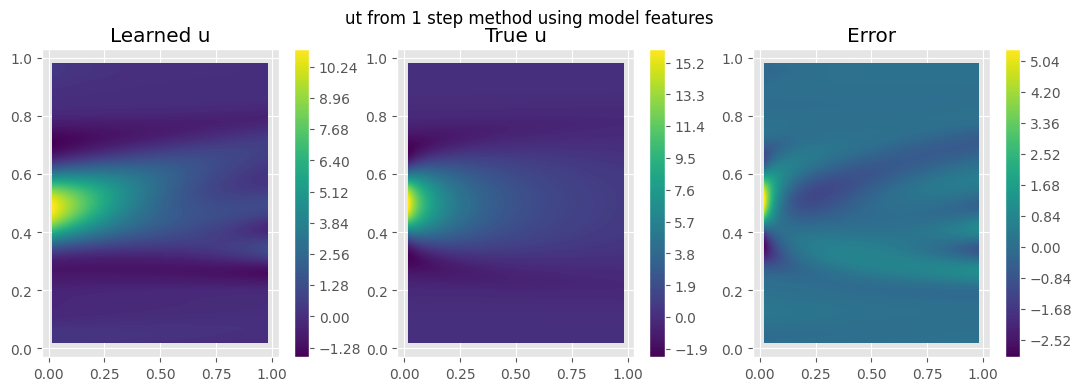

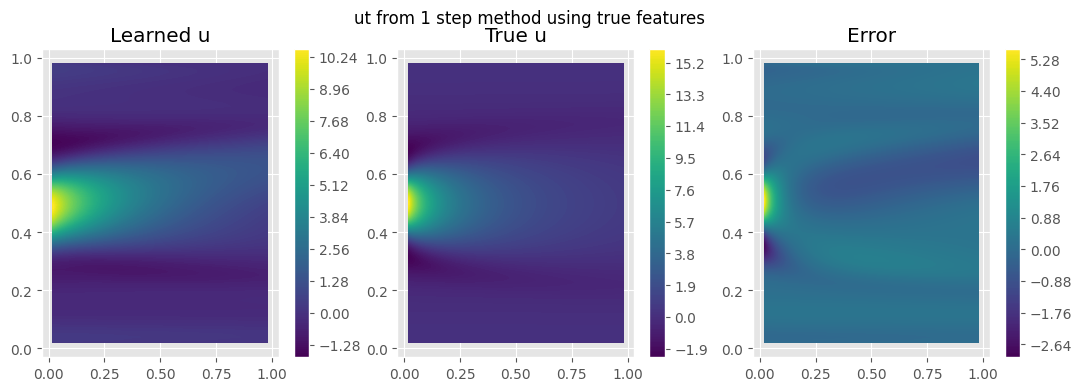

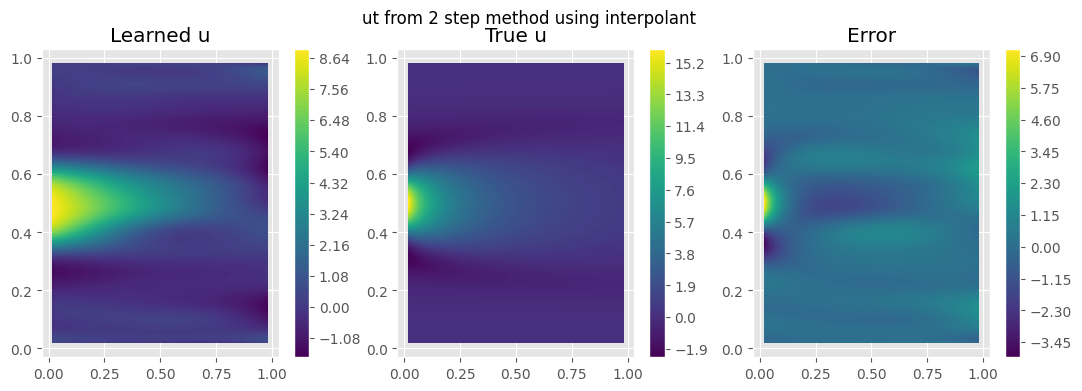

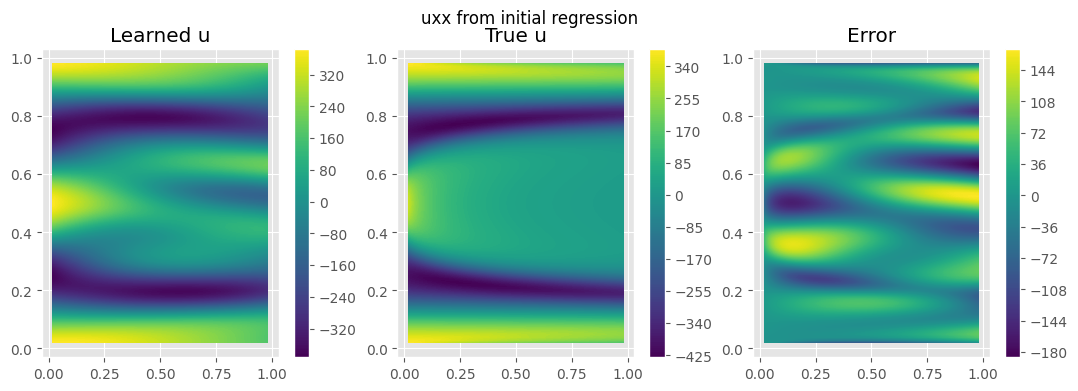

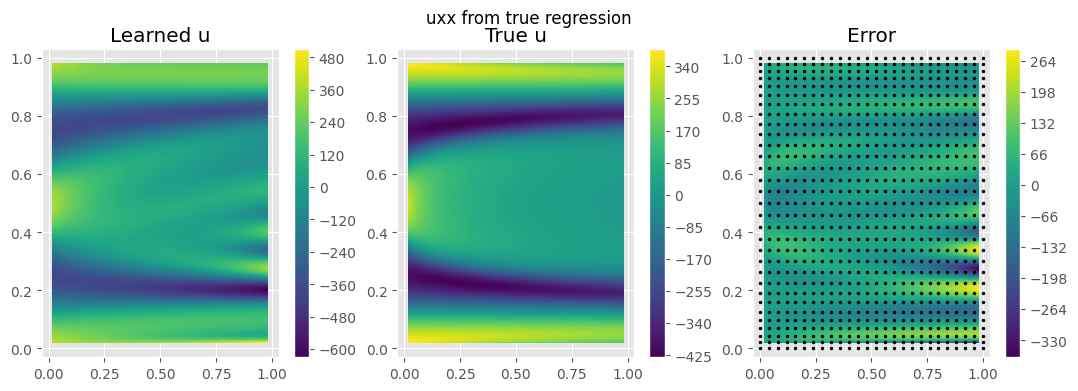

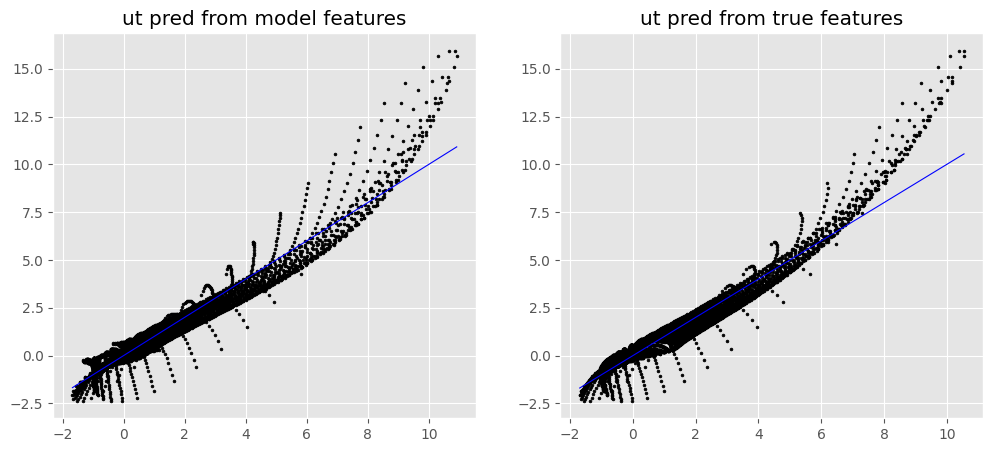

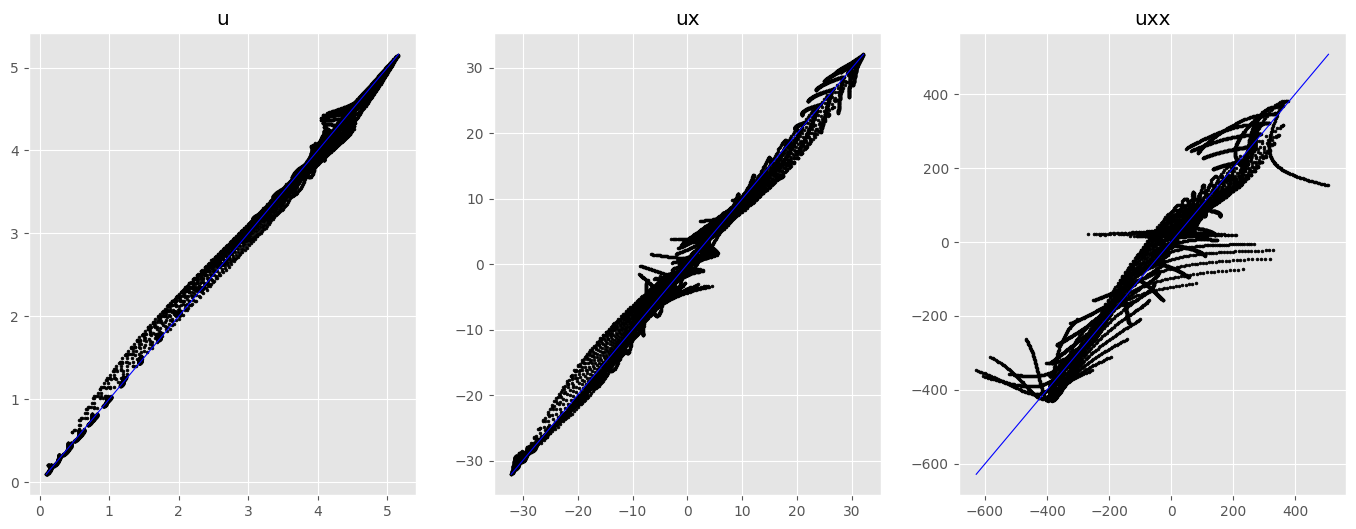

In [104]:
from plotting import compare_values,plot_compare_error_values

plot_compare_error_values(
    tx_fine_int,None,None,preds_ut_model_features,ut_true,title = "ut from 1 step method using model features"
)

plot_compare_error_values(
    tx_fine_int,None,None,preds_ut_true_features,ut_true,title = "ut from 1 step method using true features"
)

plot_compare_error_values(
    tx_fine_int,None,None,P_preds_init_model_features_init,ut_true,title = "ut from 2 step method using interpolant"
)

plot_compare_error_values(
    tx_fine_int,None,None,init_P_features_fine[:,4],uxx_true,title = "uxx from initial regression"
)

plot_compare_error_values(
    tx_fine_int,tx_all,None,model_features[:,4],uxx_true,title = "uxx from true regression"
)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,2],true_features[:,2])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,3],true_features[:,3])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,4],true_features[:,4])
plt.show()


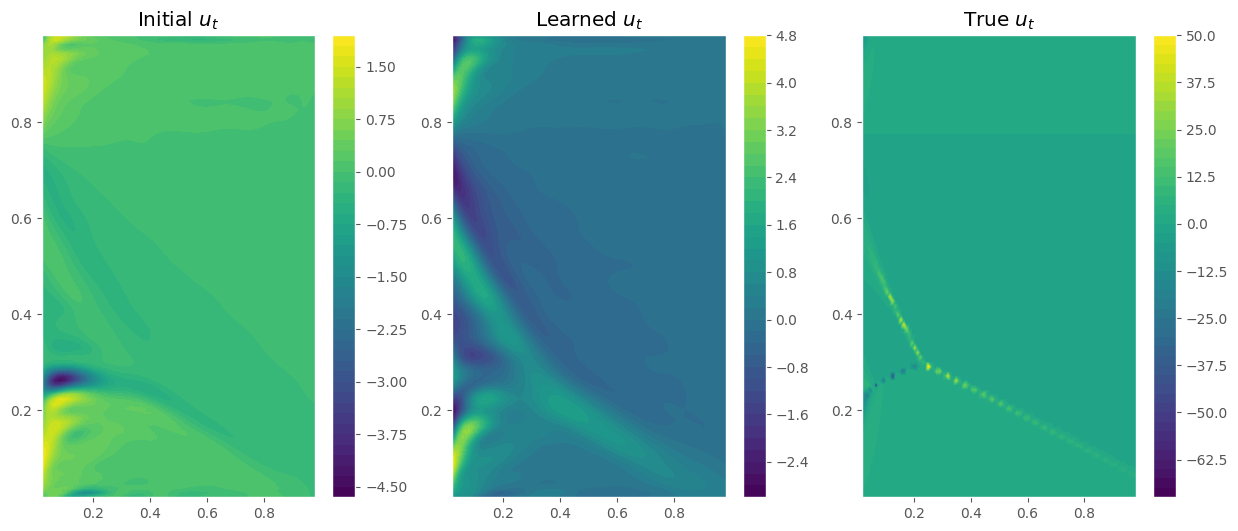

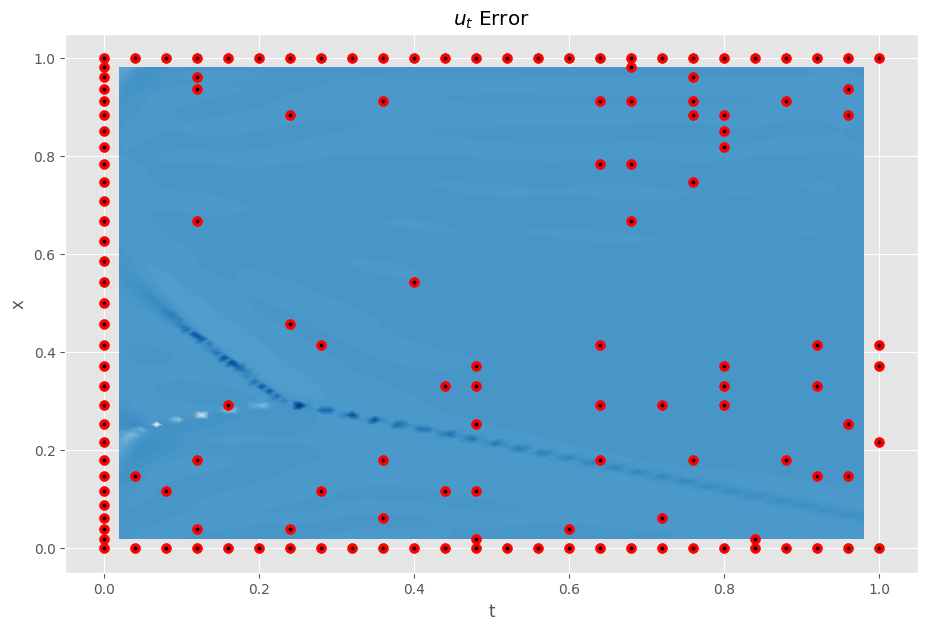

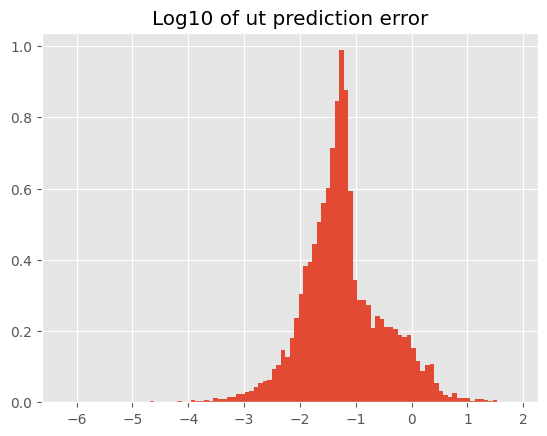

In [62]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.title("Initial $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],P_preds_init_model_features,50)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.colorbar()

plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()

  0%|          | 0/10099 [00:00<?, ?it/s]

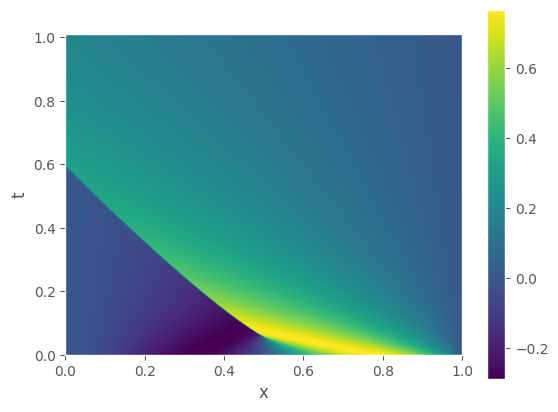

In [63]:
def new_func_u0(x):
    u0 = -1 * x * np.sin(2 * jnp.pi * x)
    return u0

new_u_true_function,new_ut_true_function,new_interp,t_vals,sols_new = (
    build_burgers_data(func_u0=new_func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

plt.imshow(sols_new[::-1],aspect = 0.8,extent = [0,1,t_vals[0],t_vals[-1]])
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.colorbar()

In [64]:
@jit
def get_pred_ut(input_features):
    return P_model.kernel_function(input_features,model_grid_features)@P_sol
tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])

new_obs = new_u_true_function(tx_init_bdy)


class PdeModel():
    datafit_weight = 50.
    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
        grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
        return jnp.hstack([tx_int,grid_features])
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators((dt_k,),tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_init_bdy,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = PdeModel.eval_obs_points(u_params)
        return new_obs - obs_preds
    
    @jit
    def equation_residual(u_params):
        P_features = PdeModel.get_grid_features(u_params)
        P_model_preds = get_pred_ut(P_features)
        ugrid_target = PdeModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(u_params):
        eqn_res = PdeModel.equation_residual(u_params)
        data_res = PdeModel.datafit_residual(u_params)
        return jnp.hstack([
            PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(u_params):
        return jnp.linalg.norm(PdeModel.F(u_params))**2
    
    @jit
    def damping_matrix(u_params):
        return u_model.kmat+1e-5 * diagpart(u_model.kmat)

In [65]:
new_u_init = 0*u_sol

u_params_pde,pde_convergence_data = LevenbergMarquadtMinimize(
    new_u_init.copy(),
    PdeModel,
    beta = 0.,
    max_iter = 101,
    init_alpha=0.05,
    line_search_increase_ratio=1.4,
    print_every = 10
)
u_pde_adj,pde_refine_conv_data = adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 1.608, Jres = 172.8, alpha = 0.04167, improvement_ratio = 0.9769
Iteration 1, loss = 0.3078, Jres = 7.935, alpha = 0.03472, improvement_ratio = 0.8692
Iteration 2, loss = 0.1414, Jres = 1.669, alpha = 0.02894, improvement_ratio = 0.9147
Iteration 3, loss = 0.1303, Jres = 0.1626, alpha = 0.02411, improvement_ratio = 1.003
Iteration 4, loss = 0.1259, Jres = 0.03763, alpha = 0.02009, improvement_ratio = 1.198
Iteration 5, loss = 0.1228, Jres = 0.03998, alpha = 0.01674, improvement_ratio = 1.244
Iteration 10, loss = 0.1131, Jres = 0.0252, alpha = 0.006729, improvement_ratio = 1.202
Iteration 20, loss = 0.1043, Jres = 0.0111, alpha = 0.001087, improvement_ratio = 1.097
Iteration 30, loss = 0.09939, Jres = 0.006783, alpha = 0.0001755, improvement_ratio = 1.042
Iteration 40, loss = 0.09455, Jres = 0.004705, alpha = 2.835e-05, improvement_ratio = 1.032
Iteration 50, loss = 0.09129, Jres = 0.001026, alpha = 4.579e-06, improvement_ratio = 1.001
Iteration 60, loss = 0.08612, J

  0%|          | 0/150 [00:00<?, ?it/s]

Sup norm error:  0.7672595474654318
NRMSE  0.5419016189035322


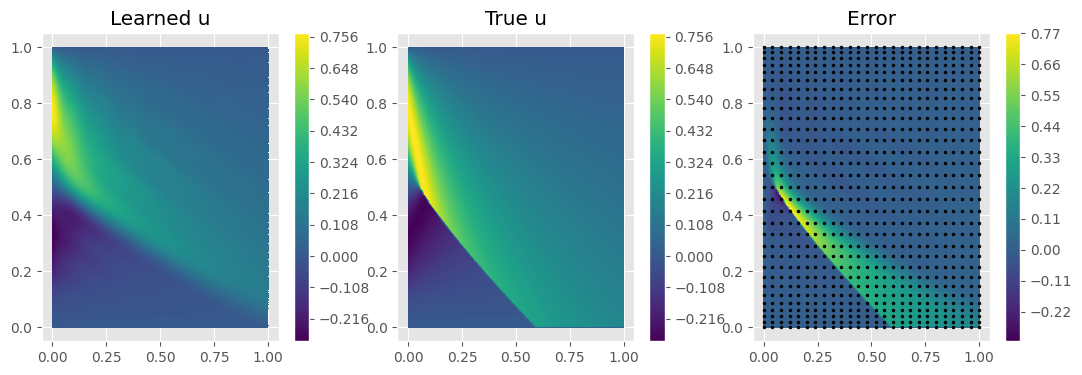

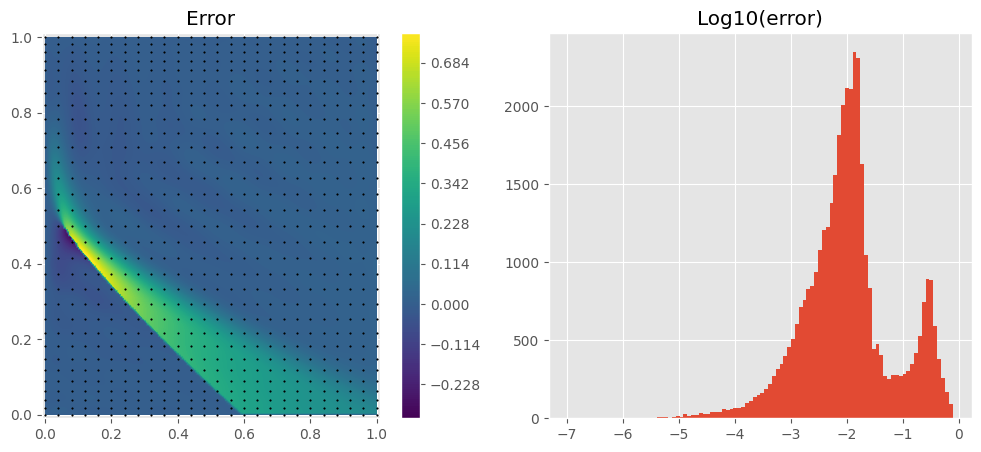

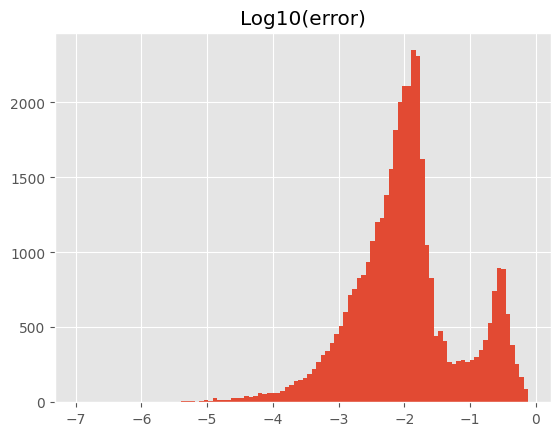

In [66]:
from plotting import plot_compare_error
new_u_eval_fine = u_model.point_evaluate(tx_grid_fine,u_pde_adj)
new_u_true_fine = new_u_true_function(tx_grid_fine)

print("Sup norm error: ",jnp.max(jnp.abs(new_u_true_fine-new_u_eval_fine)))
print("NRMSE ",get_nrmse(new_u_true_fine,new_u_eval_fine))

plot_compare_error(
    tx_grid_fine,
    tx_all,
    None,
    lambda x:u_model.point_evaluate(x,u_pde_adj),
    new_u_true_function
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine-new_u_eval_fine,200)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],s = 1,c='black')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.title("Error")
plt.subplot(1,2,2)
plt.title("Log10(error)")
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()

plt.title("Log10(error)")
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()